# Projet de programmation

## Introduction <a name="intro"></a>

Il faut récupèrer le projet avec : 

    git clone https://github.com/gwatkinson/projet-python-twitter.git

Puis, il faut créer le fichier `projet/_credentials.py`, qui contient les clés de l'API de Twitter.

Dans le format suivant :

```python
credentials = {
    "consumer_key": "XXXXXXX",
    "consumer_secret": "XXXXXXX",
    "access_token": "XXXXXXX",
    "access_token_secret": "XXXXXXX",
}
```

Finalement, il suffit d'executer les cellules de ce notebook dans l'ordre.

## Table des matières

* [Introduction](#intro)
* [1)Récupération des données](#data)
* [2)Modélisation](#model)
    * [a.Prepocessing](#process)
    * [b.Clustering](#cluster)
* [3)Visualisation](#visu)
    * [a.Nuages de mots](#cloud)
    * [b.Carte interactive](#map)
* [Conclusion](#conc)
* [Annexes](#annex)

## 1) Récupération des données <a name="data"></a>



Nous avons utilisé l'**API** de Twitter pour récupérer les nouveaux tweets publiés sur Twitter, la nuit du 3 au 4 Novembre 2020 (la nuit de l'éléction américaine). Nous avons seulement récupérer les tweets qui contennaient certains mots :

In [1]:
# Liste 3 sur Trump et Biden uniquement
liste_3 = [
    "biden",
    "trump",
    "JoeBiden",
    "realDonaldTrump",
]

# Liste 4 sur le thème 'vote'
liste_4 = [
    "iwillvote",
    "govote",
    "uselection",
    "vote",
]

# Liste 5 sur le thème 'election'
liste_5 = [
    "uselection",
    "president",
    "presidentialelection",
    "presidential",
    "electionnight",
]

Pour cela, nous avons utilisé le module python `tweepy` ainsi que les fonctions codées dans le module `streaming` (voir la documentation pour plus d'information sur [`start_stream`](https://gwatkinson.github.io/projet-python-twitter/streaming.html#projet_python_twitter.streaming.start_stream)). Voici un exemple d'utilisation du code que nous avons écrit :

In [2]:
import projet.streaming as stream                           # Contient les fonctions pour le streaming
import projet.listes_mots as listes                         # Contient les listes de mots
import projet._credentials as cred                          # Contient les clés d'authentification à l'API

credentials = stream.CredentialsClass(cred.credentials)     # Pour se connecter à l'API (il faut le fichier projet/_credentials.py)

stream.start_stream(
    credentials=credentials,
    liste_mots=listes.liste_3,                              # Liste des mots à tracker (voir `projet.listes_mots`)
    nb=200,                                                 # Nombre de tweets à recupérer
    # timeout=10/3600,                                        # Durée du stream
    fprefix="exemple_liste_3",                              # À modifier en fonction de la liste selectionnée
    path="./data/json/",                                    # À modifier selon l'utilisateur (doit finir par "/" ou "\")
    verbose=True,
)

Début du stream
Progress: [------------------->] 100 %
Les 200 tweets ont été récupérés.
Le stream a duré : 0.0h
Fin du stream


Un fichier `json` a été créé dans `data/json/`.

Pour voir à quoi ressemble les données :

In [3]:
import glob
import json
import pandas as pd

path = glob.glob("data/json/exemple_liste_3*.json")[-1]  # On récupère le dernier fichier exemple crée
print("On regarde le fichier : "+path+"\n")

tweets_list = []
with open(path, "r") as fh:
    file = fh.read().split("\n")
    for line in file:
        if line:
            tweets_list.append(json.loads(line))

print("Le premier tweet :")
print(tweets_list[0])


On regarde le fichier : data\json\exemple_liste_3_20201210-214957.json

Le premier tweet :
{'created_at': 'Thu Dec 10 20:49:52 +0000 2020', 'id': 1337137480613711876, 'id_str': '1337137480613711876', 'text': "RT @bradheath: Pennsylvania also notes that Texas' ridiculous statistical analysis of how improbable it would be for Biden to have won the…", 'source': '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>', 'truncated': False, 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 275619035, 'id_str': '275619035', 'name': 'Sam Burling', 'screen_name': 'wolfpac_five', 'location': 'Rhode Island', 'url': None, 'description': 'soccer fan, veteran, runner, views expressed are my own. Proud father to an Angel Baby and a Rainbow Daughter.', 'translator_type': 'none', 'protected': False, 'verified': False, 'followers_count': 322, 'friends_c

Il s'agit du format `json`. Il est difficile de voir les variable comme cela. On peut créer une `dataframe pandas` pour mieux comprendre les données.

In [4]:
df_tweets = pd.DataFrame(tweets_list)
df_tweets.head()

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,lang,timestamp_ms,display_text_range,extended_entities,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,extended_tweet
0,Thu Dec 10 20:49:52 +0000 2020,1337137480613711876,1337137480613711876,RT @bradheath: Pennsylvania also notes that Te...,"<a href=""http://twitter.com/#!/download/ipad"" ...",False,NaN,None,NaN,None,...,en,1607633392848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Thu Dec 10 20:49:52 +0000 2020,1337137480290676737,1337137480290676737,@realDonaldTrump https://t.co/i4oh7r8VGa,"<a href=""http://twitter.com/download/iphone"" r...",False,1.337131e+18,1337131119632916481,25073877.0,25073877,...,und,1607633392771,"[16, 16]","{'media': [{'id': 1337137475563753472, 'id_str...",False,NaN,NaN,NaN,NaN,NaN
2,Thu Dec 10 20:49:52 +0000 2020,1337137480609509395,1337137480609509395,Treason,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,None,NaN,None,...,en,1607633392847,NaN,NaN,NaN,1.337136e+18,1337135543373733889,{'created_at': 'Thu Dec 10 20:42:10 +0000 2020...,"{'url': 'https://t.co/UaQQUAtixW', 'expanded':...",NaN
3,Thu Dec 10 20:49:52 +0000 2020,1337137480592711684,1337137480592711684,"RT @gatewaypundit: President Trump Tweets - ""P...","<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,...,en,1607633392843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Thu Dec 10 20:49:52 +0000 2020,1337137480642990081,1337137480642990081,RT @RealMattCouch: Any AG in a state that Pres...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,...,en,1607633392855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print("Dimensions : ", df_tweets.shape)

Dimensions :  (200, 36)


In [6]:
print("Colonnes :\n")
for name in list(df_tweets):
    print(name)

Colonnes :

created_at
id
id_str
text
source
truncated
in_reply_to_status_id
in_reply_to_status_id_str
in_reply_to_user_id
in_reply_to_user_id_str
in_reply_to_screen_name
user
geo
coordinates
place
contributors
retweeted_status
is_quote_status
quote_count
reply_count
retweet_count
favorite_count
entities
favorited
retweeted
filter_level
lang
timestamp_ms
display_text_range
extended_entities
possibly_sensitive
quoted_status_id
quoted_status_id_str
quoted_status
quoted_status_permalink
extended_tweet


## 2) Modélisation <a name="model"></a>

### a. Preprocessing <a name="process"></a>

Nous avons fait une fonction qui fait les étapes précédentes ainsi que des fonctions pour nettoyer les données. Elles sont dans le fichier `processing.py`.

In [1]:
import projet.processing as process                         # Contient les fonctions pour le processing de la dataframe

folder = "./data/json/"                                     # Pour écupèrer tous les fichiers json dans le dossier 'data/json/'

dirty_df = process.tweet_json_to_df(folder=folder, verbose=True)     # Convertit les json en dataframe pandas


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
La conversion des fichiers 'json' a commencé, cela peut prendre du temps
File 1/8: [------------------>] 100 %
File 2/8: [------------------>] 100 %
File 3/8: [------------------>] 100 %
File 4/8: [------------------>] 100 %
File 5/8: [------------------>] 100 %
File 6/8: [------------------>] 100 %
File 7/8: [------------------>] 100 %
File 8/8: [------------------>] 100 %


Nous avons ainsi récupérer les fichiers dans `data/json/` dans la dataframe pandas `dirty_df`.

Elle ressemble à :

In [4]:

dirty_df.head()

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,lang,timestamp_ms,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,display_text_range,possibly_sensitive,extended_tweet,extended_entities
0,Thu Dec 10 11:02:36 +0000 2020,1336989688167587848,1336989688167587848,RT @SebGorka: I’m telling President @realDonal...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,None,...,en,1607598156383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Thu Dec 10 11:02:36 +0000 2020,1336989688154869760,1336989688154869760,RT @LilyMasonPhD: The fact that most GOP leade...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,...,en,1607598156380,1.336790e+18,1336790252963303425,{'created_at': 'Wed Dec 09 21:50:07 +0000 2020...,"{'url': 'https://t.co/W3VabzdvhV', 'expanded':...",NaN,NaN,NaN,NaN
2,Thu Dec 10 11:02:36 +0000 2020,1336989688565964801,1336989688565964801,RT @WalshFreedom: I love democracy.\n\nSo fuck...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,...,en,1607598156478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Thu Dec 10 11:02:36 +0000 2020,1336989688612220928,1336989688612220928,@Thinkingifree17 @llgraves @AngelaBelcamino @r...,"<a href=""http://twitter.com/download/android"" ...",False,1.336982e+18,1336981556540403712,8.482265e+17,848226546624200704,...,en,1607598156489,NaN,NaN,NaN,NaN,"[84, 128]",NaN,NaN,NaN
4,Thu Dec 10 11:02:36 +0000 2020,1336989688612212736,1336989688612212736,RT @jenniferatntd: So evil! And he admitted th...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,None,...,en,1607598156489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On peut ensuite utiliser `clean_df` pour nettoyer la base de donnée en conservant seulement les informations qui nous interressent. On peut aussi utiliser une liste de `listes_variables` pour récupérer d'autres variables ou en ajouter dans l'option `extra` de `clean_df`.

In [2]:
clean_df = process.clean_df(dirty_df, verbose=True)

Le nettoyage a commencé
Progress: [------------------->] 100 %


In [3]:
text_df = process.create_full_text(clean_df)

In [8]:
politic_df = process.add_politics(text_df)

In [9]:
politic_df[["full_text", "contains_trump", "contains_biden"]].head()

,full_text,contains_trump,contains_biden
id,,,
1336989688167587848,I’m telling President @realDonaldTrump to stri...,True,False
1336989688154869760,The fact that most GOP leaders don't condemn a...,False,False
1336989688565964801,I love democracy.\n\nSo fuck Trump. And fuck m...,True,False
1336989688612220928,@Thinkingifree17 @llgraves @AngelaBelcamino @r...,True,False
1336989688612212736,So evil! And he admitted the purpose of releas...,True,False


In [51]:
from importlib import reload
reload(process)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<module 'projet.processing' from 'c:\\Users\\gabri\\OneDrive\\Desktop\\projet-python-twitter\\projet\\processing.py'>

In [47]:
sentiment_df = process.add_sentiment(politic_df)

<AxesSubplot:ylabel='Frequency'>

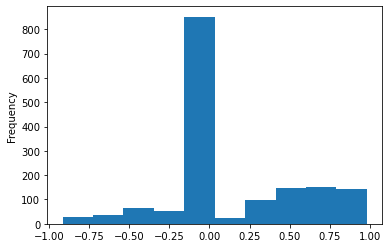

In [64]:
sentiment_df["user-description-sentiment-compound"].plot.hist()

In [52]:
final_df = process.sentiment_class(sentiment_df)

In [67]:
sum(final_df["user-description-contains_trump"].isnull())/len(final_df)

0.2325

In [72]:
sum(~final_df["user-location"].isnull())/len(final_df)

0.563125

### b. Clustering <a name="cluster"></a>

## 3) Visualisation <a name="visu"></a>

### a. Nuages de mots <a name="cloud"></a>

### b. Carte interactive <a name="map"></a>

## Conclusion <a name="conc"></a>

## Annexes <a name="annex"></a>